<a href="https://colab.research.google.com/github/pcbl/DeepDriver/blob/master/LearnPython/Jupyter/Behavior_Clonning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
!git clone https://github.com/pcbl/DeepDriver

fatal: destination path 'DeepDriver' already exists and is not an empty directory.


In [104]:
!ls DeepDriver/LearnPython/TrainSimulatorData

driving_log.csv  IMG  TrainedModel


In [105]:
!pip3 install imgaug

In [106]:
import os
import ntpath
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random
from imgaug import augmenters as iaa

In [131]:
data_dir = 'DeepDriver/LearnPython/TrainSimulatorData'
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(data_dir,'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth',-1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\polg\Downloads\simulator-windows-64\Data\IMG\center_2020_07_13_23_03_53_057.jpg,C:\Users\polg\Downloads\simulator-windows-64\Data\IMG\left_2020_07_13_23_03_53_057.jpg,C:\Users\polg\Downloads\simulator-windows-64\Data\IMG\right_2020_07_13_23_03_53_057.jpg,0.0,0.0,0.0,0.000078
1,C:\Users\polg\Downloads\simulator-windows-64\Data\IMG\center_2020_07_13_23_03_53_158.jpg,C:\Users\polg\Downloads\simulator-windows-64\Data\IMG\left_2020_07_13_23_03_53_158.jpg,C:\Users\polg\Downloads\simulator-windows-64\Data\IMG\right_2020_07_13_23_03_53_158.jpg,0.0,0.0,0.0,0.000078
2,C:\Users\polg\Downloads\simulator-windows-64\Data\IMG\center_2020_07_13_23_03_53_259.jpg,C:\Users\polg\Downloads\simulator-windows-64\Data\IMG\left_2020_07_13_23_03_53_259.jpg,C:\Users\polg\Downloads\simulator-windows-64\Data\IMG\right_2020_07_13_23_03_53_259.jpg,0.0,0.0,0.0,0.000083
3,C:\Users\polg\Downloads\simulator-windows-64\Data\IMG\center_2020_07_13_23_03_53_359.jpg,C:\Users\polg\Downloads\simulator-windows-64\Data\IMG\left_2020_07_13_23_03_53_359.jpg,C:\Users\polg\Downloads\simulator-windows-64\Data\IMG\right_2020_07_13_23_03_53_359.jpg,0.0,0.0,0.0,0.000081
4,C:\Users\polg\Downloads\simulator-windows-64\Data\IMG\center_2020_07_13_23_03_53_460.jpg,C:\Users\polg\Downloads\simulator-windows-64\Data\IMG\left_2020_07_13_23_03_53_460.jpg,C:\Users\polg\Downloads\simulator-windows-64\Data\IMG\right_2020_07_13_23_03_53_460.jpg,0.0,0.0,0.0,0.000079


In [132]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_07_13_23_03_53_057.jpg,left_2020_07_13_23_03_53_057.jpg,right_2020_07_13_23_03_53_057.jpg,0.0,0.0,0.0,0.000078
1,center_2020_07_13_23_03_53_158.jpg,left_2020_07_13_23_03_53_158.jpg,right_2020_07_13_23_03_53_158.jpg,0.0,0.0,0.0,0.000078
2,center_2020_07_13_23_03_53_259.jpg,left_2020_07_13_23_03_53_259.jpg,right_2020_07_13_23_03_53_259.jpg,0.0,0.0,0.0,0.000083
3,center_2020_07_13_23_03_53_359.jpg,left_2020_07_13_23_03_53_359.jpg,right_2020_07_13_23_03_53_359.jpg,0.0,0.0,0.0,0.000081
4,center_2020_07_13_23_03_53_460.jpg,left_2020_07_13_23_03_53_460.jpg,right_2020_07_13_23_03_53_460.jpg,0.0,0.0,0.0,0.000079


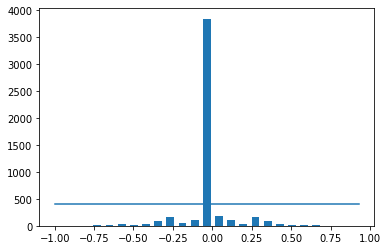

In [133]:
num_bins = 25
samples_per_bin = 400#400... Befoire was 200 but we want that the car stays a bit more on center...
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
#This shows the max. amount of samples we will accept per bin
#We do this to avoid our model to be biased to get always 0, as we have a monstruous ammount of 0 seteering
#which makes our car with a big tendency to predict straicht angle!
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

removed 3444
remaining 1615


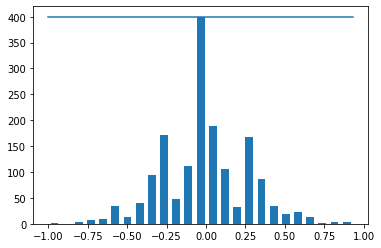

In [134]:
remove_list = []
for j  in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed', len(remove_list))
data.drop(data.index[remove_list],inplace=True)
print('remaining', len(data))

hist,_ = np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


In [135]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths,steerings

image_paths, steerings = load_img_steering(data_dir + '/IMG', data)


In [136]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {} \n Valid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1292 
 Valid Samples: 323


Text(0.5, 1.0, 'Validation set')

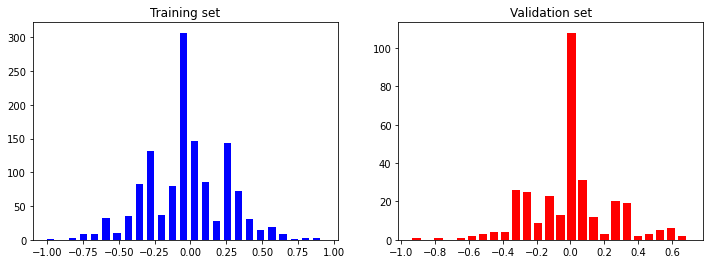

In [137]:
#Checking the balance of the test data
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [138]:
#Some augumentation techniques based on imgaug and opencv
def zoom(img):
  #Zoom up to 30%
  zoom = iaa.Affine(scale=(1, 1.3))
  img = zoom.augment_image(img)
  return img

def pan(img):
  #10% Left and Right, 10% up or down...
  pan = iaa.Affine(translate_percent={"x":(-.1,.1), "y":(-.1,.1)})
  img = pan.augment_image(img)
  return img  

def brightness(img):
  #we want a bit more dark images
  #Going from 20% brightness to 120% brightness
  #With that in mind we want more dark, so values lower than 1 are actually dark...
  brightness = iaa.Multiply((0.2,1.2))
  img = brightness.augment_image(img)
  return img    

def flip(img, steering_angle):  
  #Flipping Horizontally
  img = cv2.flip(img, 1)
  #But on that case, we need to flip the steering angle!!!!
  steering_angle = -steering_angle
  return img,steering_angle   

Text(0.5, 1.0, 'Flip 0.08593079')

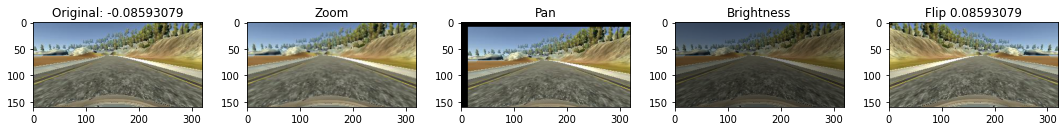

In [139]:
#Augumenting using imgaug
i=random.randint(0,len(image_paths)-1)
img = image_paths[i]
steering_angle = steerings[i]

o_img = mpimg.imread(img)
zoom_img = zoom(o_img)
pan_img = pan(o_img)
bright_img = brightness(o_img)
flip_img,steering_angle = flip(o_img,steering_angle)

fig, axes = plt.subplots(1, 5, figsize=(15,10))
fig.tight_layout()

axes[0].imshow(o_img)
axes[0].set_title('Original: '+ str(steerings[i]))

axes[1].imshow(zoom_img)
axes[1].set_title('Zoom')

axes[2].imshow(pan_img)
axes[2].set_title('Pan')

axes[3].imshow(bright_img)
axes[3].set_title('Brightness')

axes[4].imshow(flip_img)
axes[4].set_title('Flip ' + str(steering_angle))

In [140]:
def random_augument(img, steering_angle):
  img = mpimg.imread(img)
  #We want to apply transitions on 50% of the time...
  if np.random.rand()<0.5:
    img = zoom(img)
  if np.random.rand()<0.5:    
    img = pan(img)
  if np.random.rand()<0.5:    
    img = brightness(img)
  if np.random.rand()<0.5:    
    img,steering_angle = flip(img,steering_angle)
  return img,steering_angle

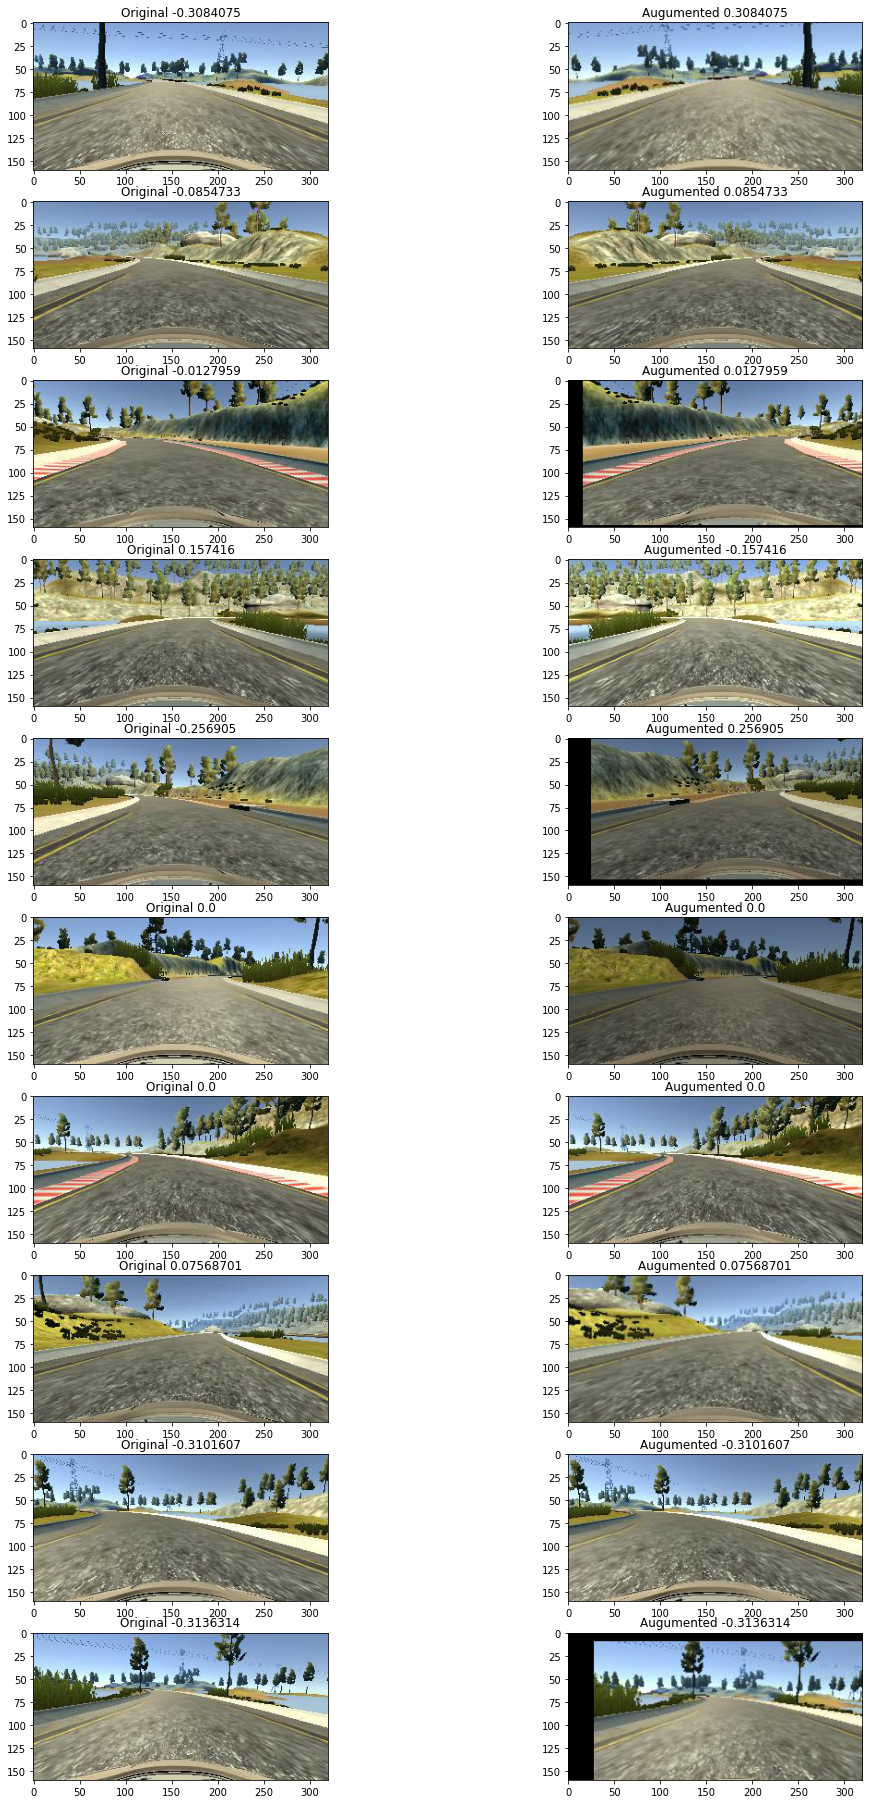

In [141]:
#Checking how out function works...
ncols = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncols, figsize=(15,25))
fig.tight_layout()

for i in range(nrow):
  rand_num = random.randint(0, len(image_paths) -1)
  randon_img = image_paths[rand_num]
  random_steering = steerings[rand_num]
  original_img = mpimg.imread(randon_img)
  augumented_img, steering = random_augument(randon_img, random_steering)

  axs[i][0].imshow(original_img)
  axs[i][0].set_title('Original ' + str(random_steering))

  axs[i][1].imshow(augumented_img)
  axs[i][1].set_title('Augumented '+ str(steering))



In [142]:
def img_preprocess(img):
  #cropping what is not needed as the sky(from 0 to 60=) and the car dash(from 135 tp 160)...  
  img = img [60:135,:,:]
  #The YUV colorspace is more efficient for Nvidia Algorithm
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  #Gaussian is a good thing to remove noise
  img = cv2.GaussianBlur(img, (3,3) , 0)
  #The Image size is somehow expected by NVidia Model
  img = cv2.resize(img, (200, 66))
  #Normalizing image by dividing by 255 to have a value between 0  and 1 on every pixel...
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

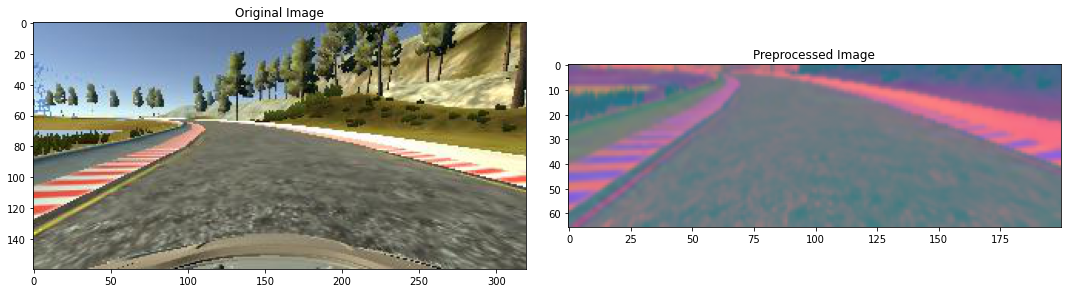

In [143]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

In [144]:
#Our Batch generator to augument images on the fly!
def batch_generator(image_paths, steering_ang, batch_size, is_training):
  while True:
    batch_img = []
    batch_steering = []

    for i in  range(batch_size):
      random_index = random.randint(0, len(image_paths) -1)

      #If training, we use the augumentation, othwerise not
      if is_training:
        img, steering = random_augument(image_paths[random_index], steering_ang[random_index])
      else:    
        img = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      img = img_preprocess(img)
      batch_img.append(img)
      batch_steering.append(steering)
    yield (np.asarray(batch_img),np.asarray(batch_steering))    

Text(0.5, 1.0, 'Validation Image')

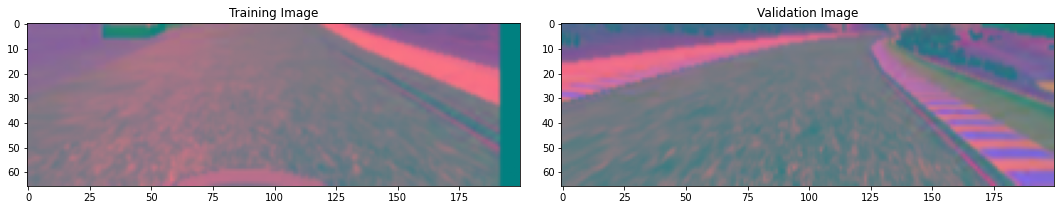

In [145]:
#Testing our batch generator
x_train_gen,y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen,y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axes = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()

axes[0].imshow(x_train_gen[0])
axes[0].set_title('Training Image')
axes[1].imshow(x_valid_gen[0])
axes[1].set_title('Validation Image')

In [122]:
#No longer needed due to generator
#X_train = np.array(list(map(img_preprocess, X_train)))
#X_valid = np.array(list(map(img_preprocess, X_valid)))

In [123]:
#No longer needed due to generator
#plt.imshow(X_train[random.randint(0,len(X_train)-1)])
#plt.axis('off')
#print(X_train.shape)

In [146]:
def nvidia_model():
  model = Sequential()
  #subsample=(2,2) means that we mode 2 px on vertical, 2 px on horizontal, as oppose to the default 1px
  model.add(Convolution2D(24, 5, 5, subsample=(2,2), input_shape = (66,200,3), activation='elu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  #model.add(Dropout(.5))#50% randomly sets to 0 to reduce overfitting
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  #model.add(Dropout(.5))#50% randomly sets to 0 to reduce overfitting
  model.add(Dense(50, activation='elu'))
  #model.add(Dropout(.6))#60% randomly sets to 0 to reduce overfitting
  model.add(Dense(10, activation='elu'))
  #model.add(Dropout(.6))#60% randomly sets to 0 to reduce overfitting
  model.add(Dense(1))
  optimizer = Adam(lr=1e-4)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [147]:
model = nvidia_model()
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 100)              

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  


In [148]:
#history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1), 
                              steps_per_epoch=300, 
                              epochs=10, 
                              validation_data=batch_generator(X_valid, y_valid, 100, 0), 
                              validation_steps=200, 
                              verbose=1, shuffle=1)

Epoch 1/10
300/300 [==============================] - 222s 741ms/step - loss: 0.0743 - val_loss: 0.0505
Epoch 2/10
300/300 [==============================] - 217s 723ms/step - loss: 0.0571 - val_loss: 0.0368
Epoch 3/10
300/300 [==============================] - 216s 719ms/step - loss: 0.0539 - val_loss: 0.0406
Epoch 4/10
300/300 [==============================] - 213s 711ms/step - loss: 0.0508 - val_loss: 0.0390
Epoch 5/10
300/300 [==============================] - 209s 696ms/step - loss: 0.0497 - val_loss: 0.0344
Epoch 6/10
300/300 [==============================] - 206s 688ms/step - loss: 0.0482 - val_loss: 0.0383
Epoch 7/10
300/300 [==============================] - 206s 686ms/step - loss: 0.0461 - val_loss: 0.0377
Epoch 8/10
300/300 [==============================] - 208s 692ms/step - loss: 0.0438 - val_loss: 0.0331
Epoch 9/10
300/300 [==============================] - 207s 689ms/step - loss: 0.0434 - val_loss: 0.0333
Epoch 10/10
300/300 [==============================] - 206s 686m

Text(0.5, 0, 'epoch')

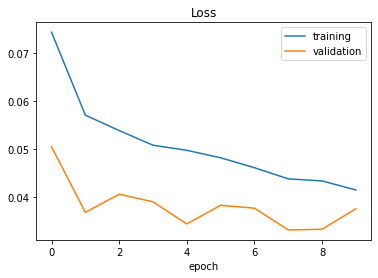

In [149]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')

In [150]:
model.save('model.h5')

In [151]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>